In [2]:
import numpy as np
%load_ext autoreload
%autoreload 2
from tic_env import TictactoeEnv, OptimalPlayer
from utils import play_game, Metric
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm_notebook
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#define state table with all possible combinations.
boards = []
for i in range(0 , 19683) : 
    c=i
    temp_boards = []
    for ii in range(0 , 9) : 
        temp_boards.append(c % 3)
        c = c // 3
    boards.append(temp_boards)
boards=np.array(boards)
boards[boards == 0]= -1
boards[boards == 2]= 0
boards=boards.tolist()

In [3]:

def dec_exp(n, n_, e_min=.1, e_max=.8):
    #helper function for decreasing exploration rate.
    return max(e_min,e_max*(1- n/n_))


def get_state(grid,player,boards=boards):
    #helper function to get the state from the grid. the sign changes for each player.
    #the state hash is the index of the board in the boards table
    sign={'X':1,'O':-1}
    return boards.index((sign[player.player]*grid.flatten().astype('int32')).tolist())

class Q_player:
    def __init__(self,player='X', epsilon=0):
        self.player=player
        self.epsilon=epsilon
    def empty(self, grid):
        '''return all empty positions'''
        grid=grid.flatten()
        avail = []
        for i in range(9):
            if grid[i] == 0:
                avail.append(i)
        return avail

    
        
    def act(self,state, grid, q_table):
        avail=self.empty(grid)
        
        action_scores = q_table[state,:].copy()
        
        mask=np.ones(action_scores.shape,dtype=bool)
        mask[avail]=False
        action_scores[mask]= -np.inf    #not available positions Q_values are set to -inf
        
        action = np.random.choice(np.where(action_scores == np.max(action_scores))[0])
        if np.random.random() < self.epsilon:
            action = np.random.choice(avail)
        
        return action

def Metric_Q(policy,Q_table,optimal=False):
    #computes the metrics from a given policy. optimal argument set the optimal or random
    #opponent
    N_wins=0
    N_losses=0
    N=0
    Turns = np.array([['X','O']]*250+[['O','X']]*250)
    for i in range(500):
        np.random.seed()

        
        if optimal: 
            player_test = OptimalPlayer(epsilon=0., player=Turns[i,1])
        if not optimal:
            player_test = OptimalPlayer(epsilon=1., player=Turns[i,1])

        player_new = policy(player=Turns[i,0],epsilon=0)
        env=TictactoeEnv()
        while not env.end:
            if env.current_player == player_new.player:
                state=get_state(env.grid,player_new)
                move = player_new.act(state,env.grid,Q_table)       
            else:
                move = player_test.act(env.grid)

            if not isinstance(move,tuple): 
                    move=(int(move/3),move%3)
            env.step(move, print_grid=False)
                
        if env.winner==player_new.player:
            N_wins+=1
        if env.winner==player_test.player:
            N_losses+=1
        N+=1
        env.reset()               
    return (N_wins - N_losses)/N

def play_game_selfQ(env,Q_table,p1,p2,alpha=0.05,gamma=0.99):
    #play a self-learning game  and updates the Q-table
    while not env.end:
        if env.current_player == p1.player:
            state1=get_state(env.grid,p1)
            action1=p1.act(state1,env.grid,Q_table)
            env.step((int(action1/3), action1 % 3), print_grid=False)
            reward1=env.reward(p1.player)
            new_state1=get_state(env.grid,p1)
        
            Q_table[state1,action1] += alpha*(reward1 + gamma*(np.max(Q_table[new_state1,:])) - Q_table[state1,action1])
            if env.end:
                reward2=env.reward(p2.player)
                Q_table[state2,action2] += alpha*(reward2 +gamma*(np.max(Q_table[new_state2,:]))- Q_table[state2,action2])
        else:
            state2=get_state(env.grid,p2)
            action2=p2.act(state2,env.grid,Q_table)
            env.step((int(action2/3), action2 % 3), print_grid=False)
            reward2=env.reward(p2.player)
            new_state2=get_state(env.grid,p2)
            
            Q_table[state2,action2] += alpha*(reward2 + gamma*(np.max(Q_table[new_state2,:])) - Q_table[state2,action2])
            if env.end:
                reward1=env.reward(p1.player)
                Q_table[state1,action1] += alpha*(reward1 +gamma*(np.max(Q_table[new_state1,:]))- Q_table[state1,action1])
        
    return env


In [ ]:
n_states=3**9
n_actions=9
M_opts=pd.DataFrame()
M_rands=pd.DataFrame()

for n_ in [5000,10000,15000,20000]:
    M_opt=[]
    M_rand=[]
    p1=Q_player(player='X')
    p2=Q_player(player='O')
    Q_table=np.zeros((n_states,n_actions))
    env=TictactoeEnv()
    for game in tqdm_notebook(range(20000),unit='game'):
        epsilon=dec_exp(game, n_)
        if game%250==0:
            #log metrics every 250 games
            print(game,'eps',epsilon)
            M_opt.append(Metric_Q(Q_player, Q_table, optimal=True))
            M_rand.append(Metric_Q(Q_player, Q_table, optimal=False))
            print('M_opt', M_opt[-1])
            print('M_rand', M_rand[-1])
        if game%2==0:
            #alternates the player and sets the new epsilons
            p1.player='X'
            p1.epsilon=epsilon
            p2.player='O'
            p2.epsilon=epsilon
        else:
            p1.player='O'
            p1.epsilon=epsilon
            p2.player='X'
            p2.epsilon=epsilon

        env_end=play_game_selfQ(env,Q_table,p1,p2)
        env.reset()
        
    M_opts[n_]=M_opt
    M_rands[n_]=M_rand

    print(np.sum(Q_table))


X wins 0.47135
O wins 0.29465
Draws 0.234


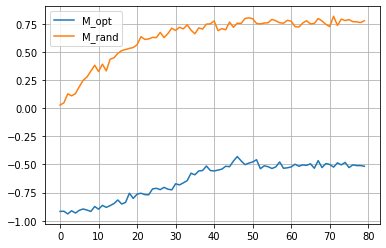

In [14]:
#if only one run
plt.plot(range(len(M_opt)),M_opt,label='M_opt')
plt.plot(range(len(M_rand)),M_rand,label='M_rand')
plt.legend()
plt.grid()

print('X wins',res.count('X')/len(res))
print('O wins',res.count('O')/len(res))
print('Draws',res.count(None)/len(res))

(-1.0, 1.0)

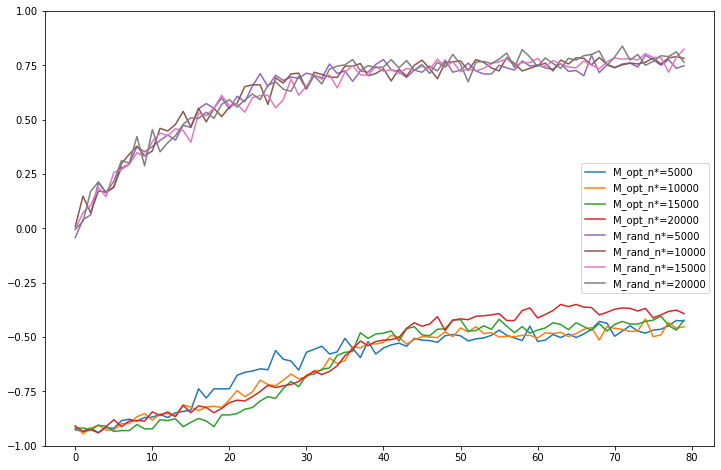

In [10]:
#if multiple runs
plt.figure(figsize=(12,8))
for eps in M_opts.columns:
    plt.plot(range(len(M_opts)),M_opts[eps],label='M_opt_n*='+str(eps))
for eps in M_opts.columns:
    plt.plot(range(len(M_opts)),M_rands[eps],label='M_rand_n*='+str(eps))
plt.legend()
plt.ylim(-1,1)

In [33]:
print(np.count_nonzero(Q_table),3**9-np.count_nonzero(Q_table))

9040 10643


[[-1  1 -1]
 [ 1  1 -1]
 [ 0 -1  0]]


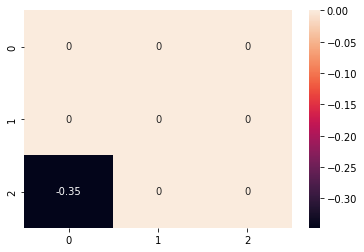

In [32]:
#to check the Q-vals from a given state
board=[-1,1,-0,0,0,0,0,0,0]
sns.heatmap(Q_table[boards.index(board)].reshape(3,3),annot=True)
print(np.array(boards[boards.index(board)]).reshape(3,3))

In [426]:
len([])


0